## Data Analysis for Alarm parameters
`To find optimal control parameters for normal machine operation.`

### Import packages

In [1]:
# Standard operational package imports.
import numpy as np
import pandas as pd
from datetime import datetime as dt

# Visualization package imports.
import matplotlib.pyplot as plt
import seaborn as sns

# Additional unofficial packages for importing data
from Utilities import * # self-created packages for retrieving data from PI system

### Retrieving data from PI system
*this step use confidential information*

In [3]:
# Define parameters to use in function
access_token = {'user' :'xxxxxxxx','pass' : 'xxxxxxx'}
startdate = '2023-07-01'
enddate = dt.today().date()
pi_list = ['PVC9-EIC4501B.PV', 'PVC9-EIC4501B.SV']
interval_time = '1s'
server = 'MOC'

In [26]:
# Get sensor data from PI system and load it into dataframe
# df_pi = retrieve_piDATA(startdate, enddate, pi_list, interval_time, server, access_token)

In [254]:
# Export data to csv file for further uses.
# df_pi.to_csv(f'PIdata_{startdate}_{interval_time}.csv', index = False)

I already saved PI data in csv file so I decided to read data from csv file instead.

In [4]:
df_pi = pd.read_csv('PIdata_2023-07-01_1s.csv')

### Explore and Transform Data

Display top 5 rows from the dataframe

In [5]:
df_pi.head()

,Date,PVC9-EIC4501B.PV,PVC9-EIC4501B.SV
0,2023-07-01 00:00:00,164.519312,165.0
1,2023-07-01 00:00:01,164.508885,165.0
2,2023-07-01 00:00:02,164.498459,165.0
3,2023-07-01 00:00:03,164.488032,165.0
4,2023-07-01 00:00:04,164.477605,165.0


Column name did not explain values in its column so I will rename them to make it more accurate. 

In [6]:
df_pi.columns = ['Date', 'Actual', 'Set']

In [7]:
df_pi.shape

(7430400, 3)

The dataframe contains 7,430,400 rows and 3 columns.

In [8]:
df_pi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7430400 entries, 0 to 7430399
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Actual  float64
 2   Set     float64
dtypes: float64(2), object(1)
memory usage: 170.1+ MB


"Date" column's data type is not correct. Transform the data type into datetime.

In [9]:
df_pi['Date'] = pd.to_datetime(df_pi['Date'])

**Check missing values in the dataframe**

In [10]:
(df_pi.isna().sum()/len(df_pi))*100

Date      0.000000
Actual    0.353803
Set       0.015652
dtype: float64

"Actual" column and "Set" column has 0.35% and 0.02% of missing values respectively.\
These are considered as very small amount so I remove it all.

In [11]:
df_pi.dropna(axis = 0, inplace = True)

In [12]:
# Check missing values again
df_pi.isna().sum()

Date      0
Actual    0
Set       0
dtype: int64

There are no missing values left.

Next, I want to calculate avarage value (mean) and standard deviation (SD) from actual read data for each set point group to set alarm boundary with 3 SD from set point.\
So I check the set point data if they can be grouped. 

In [13]:
# check first 10 setting values from PI
df_pi['Set'].unique().tolist()[:10]

[165.0,
 164.99999999154824,
 164.99164988199868,
 164.97498321533203,
 164.95831654866538,
 164.9416498819987,
 164.92498321533202,
 164.90831654866537,
 164.89164988199872,
 164.87498321533204]

From the results, the setting values are vary and might be too specific so I round it up to integer and add it to new column named 'Set_point'

In [14]:
# round up setting value for grouping
df_pi['Set_point'] = round(df_pi['Set'])
df_pi.head()

,Date,Actual,Set,Set_point
0,2023-07-01 00:00:00,164.519312,165.0,165.0
1,2023-07-01 00:00:01,164.508885,165.0,165.0
2,2023-07-01 00:00:02,164.498459,165.0,165.0
3,2023-07-01 00:00:03,164.488032,165.0,165.0
4,2023-07-01 00:00:04,164.477605,165.0,165.0


**Find mean value and standard deviation for each Set_point**

In [15]:
# find average value and standard deviation
df_group = df_pi.groupby('Set_point').agg(mean = ('Actual', 'mean'), standard = ('Actual', 'std')).reset_index()
df_group

,Set_point,mean,standard
0,100.0,129.898786,2.532789
1,101.0,129.807273,5.045454
2,102.0,129.738034,6.343199
3,103.0,102.578300,1.070147
4,104.0,103.853693,3.000247
...,...,...,...
63,163.0,162.962532,0.990579
64,164.0,163.945768,0.937702
65,165.0,164.972671,0.880218
66,166.0,165.832006,1.049179


Plot graph to see relation between mean value and set point. 

<Axes: xlabel='Set_point', ylabel='mean'>

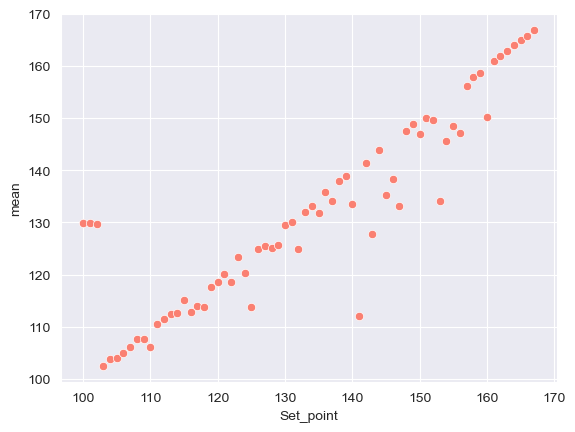

In [16]:
# compare value between Set data point and mean value
sns.set_style('darkgrid')
sns.scatterplot(df_group, x = 'Set_point', y = 'mean', color = 'salmon')

From the plot above, some avarage value is much difference from its set point. If we use 3 SD, the alarm boundary might not be accurate due to some outliers in each set point.\
I decided to use box plot to check data at set point equals 141 (mean value is much difference from set point)

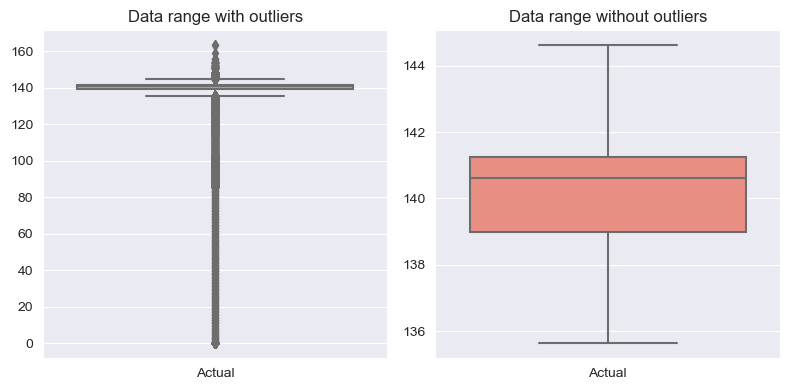

In [17]:
# Validate data with box plot
# Create boxplot with outliers compared to without outliers
fig, axes = plt.subplots(1, 2, figsize = (8,4))
sns.boxplot(data = df_pi[df_pi['Set_point'] == 141][['Actual']], 
            showfliers = True, color = 'salmon', 
            ax = axes[0])
axes[0].set_title("Data range with outliers")

# Create boxplot without outliers
sns.boxplot(data = df_pi[df_pi['Set_point'] == 141][['Actual']], 
            showfliers = False, color = 'salmon', 
            ax = axes[1])
axes[1].set_title("Data range without outliers")

# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance.
plt.tight_layout()

# Show the plot.
plt.show()

When remove outliers, the result makes more sense.\
Use 1.5 IQR from box plot might be more reliable to set alarm boundary since it removes outliers.

In [18]:
# define function to calculate uppper and lower boundary
def box_param(data):
    '''
        This function will return lower and upper boundary respectively from input data as dictionary
    '''
    data = data.dropna()
    Q1 = np.quantile(data, 0.25)
    Q3 = np.quantile(data, 0.75)
    IQR = Q3 - Q1
    upper_whisk = round(Q3 + (1.5 * IQR), 2)
    lower_whisk = round(Q1 - (1.5 * IQR), 2)
    
    return (lower_whisk, upper_whisk)

In [19]:
df_result = df_pi.groupby('Set_point').apply(lambda x: box_param(x['Actual'])).reset_index(name = 'Boundary')

lower_bound = []
upper_bound = []

for i in df_result['Boundary']:
    lower_bound.append(i[0])
    upper_bound.append(i[1])

df_result['lower_bound'] = lower_bound
df_result['upper_bound'] = upper_bound

df_result

,Set_point,Boundary,lower_bound,upper_bound
0,100.0,"(121.33, 138.47)",121.33,138.47
1,101.0,"(112.42, 147.22)",112.42,147.22
2,102.0,"(120.77, 138.71)",120.77,138.71
3,103.0,"(101.27, 103.85)",101.27,103.85
4,104.0,"(101.37, 105.78)",101.37,105.78
...,...,...,...,...
63,163.0,"(160.42, 165.46)",160.42,165.46
64,164.0,"(161.61, 166.26)",161.61,166.26
65,165.0,"(162.67, 167.25)",162.67,167.25
66,166.0,"(163.43, 168.19)",163.43,168.19


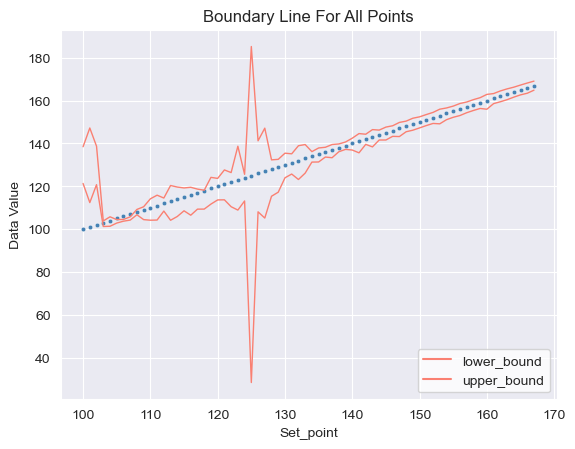

In [20]:
data_unpivot_all = pd.melt(df_result, 
                            id_vars = ['Set_point'], 
                            value_vars = ['lower_bound', 'upper_bound'], 
                            value_name = 'Data Value', 
                            var_name = 'Boundary')

sns.lineplot(data = data_unpivot_all, 
             x = 'Set_point', 
             y = 'Data Value', 
             hue = 'Boundary', 
             palette = ['salmon', 'salmon'], 
             linewidth = 1)
             
sns.scatterplot(data = df_result, x = 'Set_point', y = 'Set_point', s = 10, c = 'steelblue', marker = 'o')
plt.legend(loc = 'lower right', facecolor = 'white')
plt.title('Boundary Line For All Points')
plt.show()

From the plot above, we can see that boundary are vary a lot. This might occurs due to abnormal operation.\
So I use box plot again to check normal operation range.

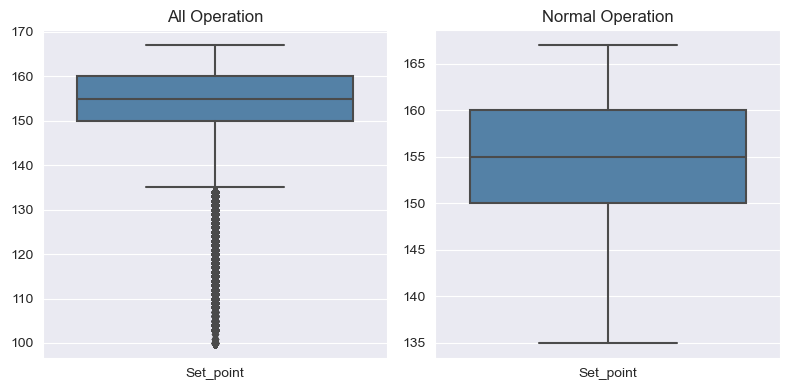

In [21]:
# Create Box plot to visualize normal operating set point
fig, axes = plt.subplots(1, 2, figsize = (8,4))
sns.boxplot(df_pi[['Set_point']], showfliers = True,  ax = axes[0], color = 'steelblue')
axes[0].set_title("All Operation")

# Create boxplot without outliers

sns.boxplot(df_pi[['Set_point']], showfliers = False, ax = axes[1], color = 'steelblue')
axes[1].set_title("Normal Operation")

# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance.
plt.tight_layout()

# Show the plot.
plt.show()

The box plot suggests that set point lower than 135 is not normal operation.\
So I filter out set point that not in this range and plot again.

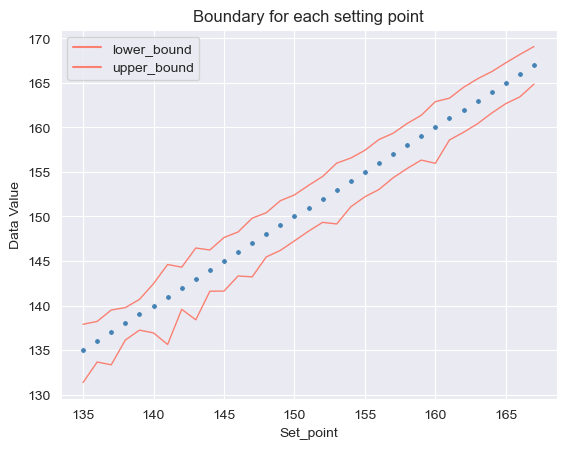

In [28]:
# filter out and plot again
set_bound = box_param(df_pi['Set_point'])

filter_df_result = (df_result['Set_point'] >= set_bound[0]) & (df_result['Set_point'] <= set_bound[1])
data = df_result[filter_df_result].reset_index(drop = True) # filter out data that not in normal range

data_unpivot = pd.melt(data, id_vars = ['Set_point'], 
                             value_vars = ['lower_bound', 'upper_bound'], 
                             value_name = 'Data Value', 
                             var_name = 'Boundary')

sns.lineplot(data = data_unpivot, 
             x = 'Set_point', 
             y = 'Data Value', 
             hue = 'Boundary', 
             palette = ['salmon', 'salmon'], 
             linewidth = 1)

sns.scatterplot(data = data, x = 'Set_point', y = 'Set_point', s = 15, c = 'steelblue', marker = 'o')

plt.title('Boundary for each setting point')
plt.show()

Visualize with box plot for each set point.

In [29]:
# Transform data for visualizing
filter_df_pi = (df_pi['Set_point'] >= set_bound[0]) & (df_pi['Set_point'] <= set_bound[1])
pi_pivot = df_pi[filter_df_pi].pivot(index = 'Date', columns = 'Set_point', values = 'Actual')

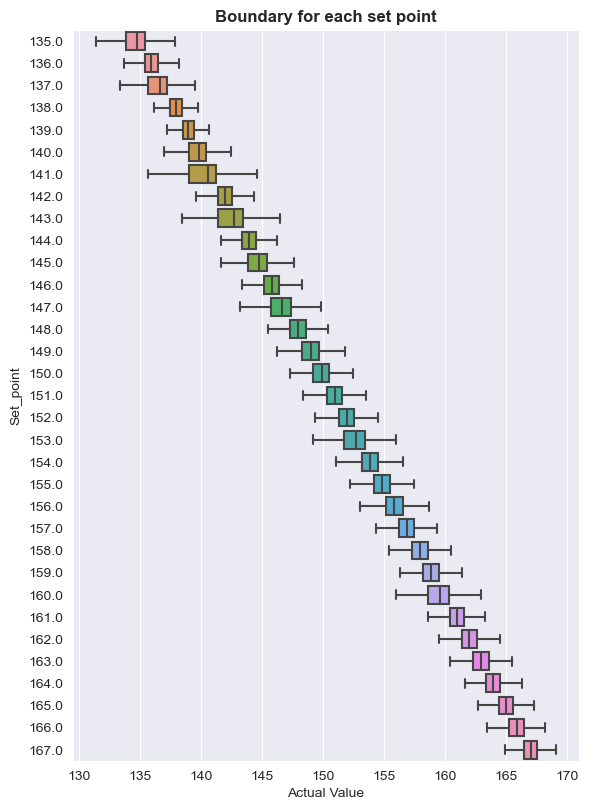

In [30]:
fig, ax = plt.subplots(figsize= (6,8))
sns.boxplot(pi_pivot, showfliers = False, orient = 'h')
plt.xlabel('Actual Value')
plt.tight_layout()
plt.title('Boundary for each set point', fontweight = 'bold')
plt.show()

Display table of data after removing abnormal point and export to excel to set boundary parameters on PI system.

In [25]:
# show result in table
display(data)

,Set_point,Boundary,lower_bound,upper_bound
0,135.0,"(131.36, 137.9)",131.36,137.90
1,136.0,"(133.66, 138.22)",133.66,138.22
2,137.0,"(133.35, 139.5)",133.35,139.50
3,138.0,"(136.13, 139.77)",136.13,139.77
4,139.0,"(137.24, 140.69)",137.24,140.69
5,140.0,"(136.93, 142.46)",136.93,142.46
6,141.0,"(135.63, 144.61)",135.63,144.61
7,142.0,"(139.58, 144.31)",139.58,144.31
8,143.0,"(138.4, 146.46)",138.40,146.46
9,144.0,"(141.61, 146.24)",141.61,146.24


In [28]:
# Export boundary data to set up on PI system
data.to_excel('Boundary_PVC9-EIC4501B.xlsx', index = False)